In [2]:
pip install lightgbm


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [167]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import numpy as np

In [168]:
# 한글 폰트 경로 설정 (시스템에 설치된 한글 폰트 경로를 사용)
font_path = r"C:\Users\dlwng\OneDrive\바탕 화면\나눔고딕\NanumGothic.ttf"  # 예시 경로
fm.fontManager.addfont(font_path)
font_prop = fm.FontProperties(fname=font_path, size=12)
plt.rcParams['font.family'] = font_prop.get_name()


In [169]:
# 데이터 불러오기
train = pd.read_csv(r"C:\Users\dlwng\OneDrive\바탕 화면\sas\TRAIN_DATA.csv", encoding='cp949')
test = pd.read_csv(r'C:\Users\dlwng\OneDrive\바탕 화면\sas\TEST_DATA.csv', encoding='cp949')

#ondo = pd.read_csv

In [170]:
df = train

# 데이터 전처리 + EDA

In [171]:
# 1. DIST_CD 분리
df['DIST_CD'] = df['DIST_CD'].astype(str)
df['SIDO_CD'] = df['DIST_CD'].str[:2]   # 시도코드
df['ADDR_CD'] = df['DIST_CD'].str[3:]   # 상세 주소 코드 (필요 시 참고)

In [172]:
# 2. SIDO 매핑 (지역 이름)
sido_code_map = {
    '11': '서울특별시', '26': '부산광역시', '27': '대구광역시', '28': '인천광역시',
    '29': '광주광역시', '30': '대전광역시', '31': '울산광역시', '36': '세종특별자치시',
    '41': '경기도', '42': '강원도', '43': '충청북도', '44': '충청남도',
    '45': '전라북도', '46': '전라남도', '47': '경상북도', '48': '경상남도',
    '49': '제주도', '50': '제주특별자치도', '51': '강원특별자치도', '52': '전북특별자치도'
}
df['SIDO_NM'] = df['SIDO_CD'].map(sido_code_map)

In [173]:
# 3. DATA_YM → datetime 변환
df['DATA_YM'] = pd.to_datetime(df['DATA_YM'].astype(str), format='%Y%m')

In [174]:
# 1. 연도 추출
df['YEAR'] = df['DATA_YM'].dt.year

# 2. 원핫인코딩 (drop_first=False이면 'YEAR_2023', 'YEAR_2024' 모두 생성됨)
df = pd.get_dummies(df, columns=['YEAR'], drop_first=False)

In [175]:
# 중복확인 
train.duplicated().sum()

754

In [176]:
train.shape

(26099, 24)

In [177]:
# 4. 중복 제거
df = df.drop_duplicates()
print(f"✅ 중복 제거 후 shape: {df.shape}")

✅ 중복 제거 후 shape: (25345, 26)


In [178]:
# 5. 결측치 처리
# 결측치 확인
print(df.isnull().sum())

# 결측치가 있는 행: 종묘앞_1 & 2023년 1월 데이터로 채우기
fill_values = df[(df['AREA_NM'] == '종묘앞_1') & (df['DATA_YM'] == pd.to_datetime('202301', format='%Y%m'))].iloc[0]
df.loc[df.isnull().any(axis=1), fill_values.index] = fill_values.values

# 인덱스 12517 삭제
df.drop(index=12517, inplace=True)

DATA_YM         0
AREA_ID         0
AREA_NM         0
DIST_CD         0
DIST_NM         0
TOTAL_BIDG      3
FAC_NEIGH_1     3
FAC_NEIGH_2     3
FAC_CULT_MTG    3
FAC_RELG        3
FAC_RETAIL      3
FAC_MEDI        3
FAC_YOSE        3
FAC_TRAIN       3
FAC_SPORT       3
FAC_STAY        3
FAC_LEISURE     3
TOTAL_GAS       0
CMRC_GAS        0
TOTAL_ELEC      0
SIDO_CD         0
ADDR_CD         0
SIDO_NM         0
YEAR_2022       0
YEAR_2023       0
YEAR_2024       0
dtype: int64


In [179]:
# 결측치 재확인 
print(f"✅ 결측치 처리 후 결측 개수:\n{df.isnull().sum()}")

✅ 결측치 처리 후 결측 개수:
DATA_YM         0
AREA_ID         0
AREA_NM         0
DIST_CD         0
DIST_NM         0
TOTAL_BIDG      0
FAC_NEIGH_1     0
FAC_NEIGH_2     0
FAC_CULT_MTG    0
FAC_RELG        0
FAC_RETAIL      0
FAC_MEDI        0
FAC_YOSE        0
FAC_TRAIN       0
FAC_SPORT       0
FAC_STAY        0
FAC_LEISURE     0
TOTAL_GAS       0
CMRC_GAS        0
TOTAL_ELEC      0
SIDO_CD         0
ADDR_CD         0
SIDO_NM         0
YEAR_2022       0
YEAR_2023       0
YEAR_2024       0
dtype: int64


In [180]:
df['AREA_ID'].value_counts().count()

1166

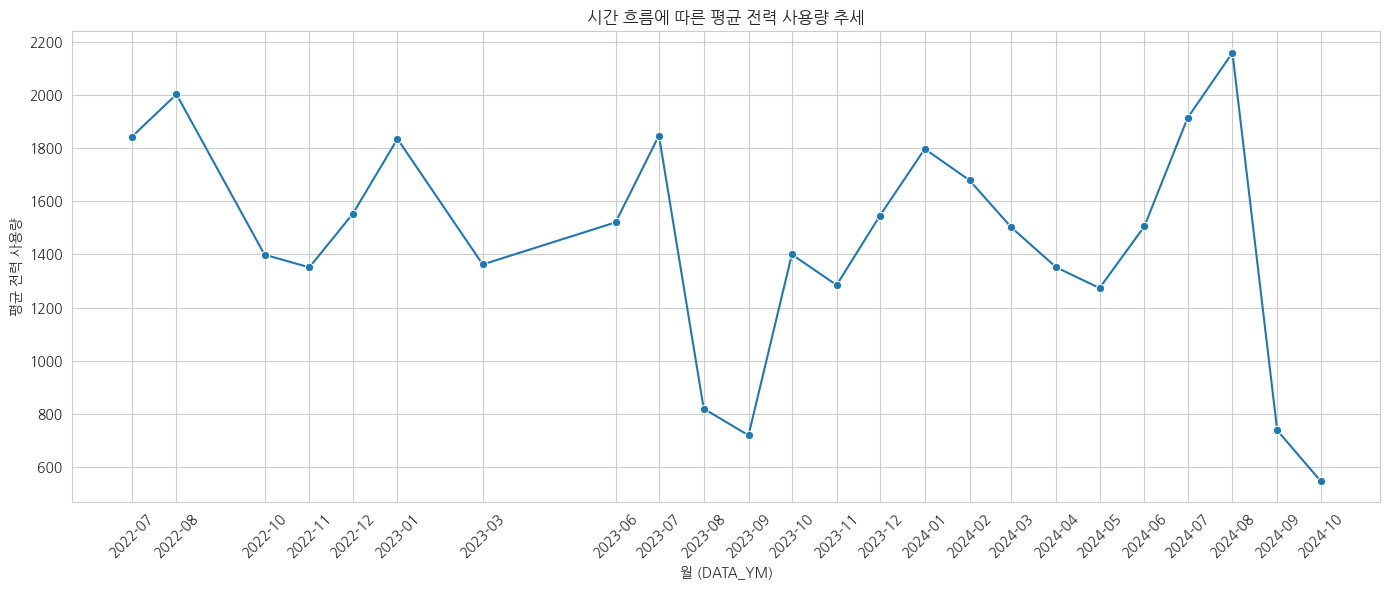

In [181]:
import matplotlib.pyplot as plt
import seaborn as sns

# 월별 평균 전력 사용량 계산
monthly_usage = df.groupby('DATA_YM')['TOTAL_ELEC'].mean()

# 시각화
plt.figure(figsize=(14, 6))
sns.lineplot(x=monthly_usage.index, y=monthly_usage.values, marker='o')

# X축에 모든 월 표시
plt.xticks(ticks=monthly_usage.index, labels=monthly_usage.index.strftime('%Y-%m'), rotation=45)

plt.title('시간 흐름에 따른 평균 전력 사용량 추세')
plt.xlabel('월 (DATA_YM)')
plt.ylabel('평균 전력 사용량')
plt.grid(True)
plt.tight_layout()
plt.show()


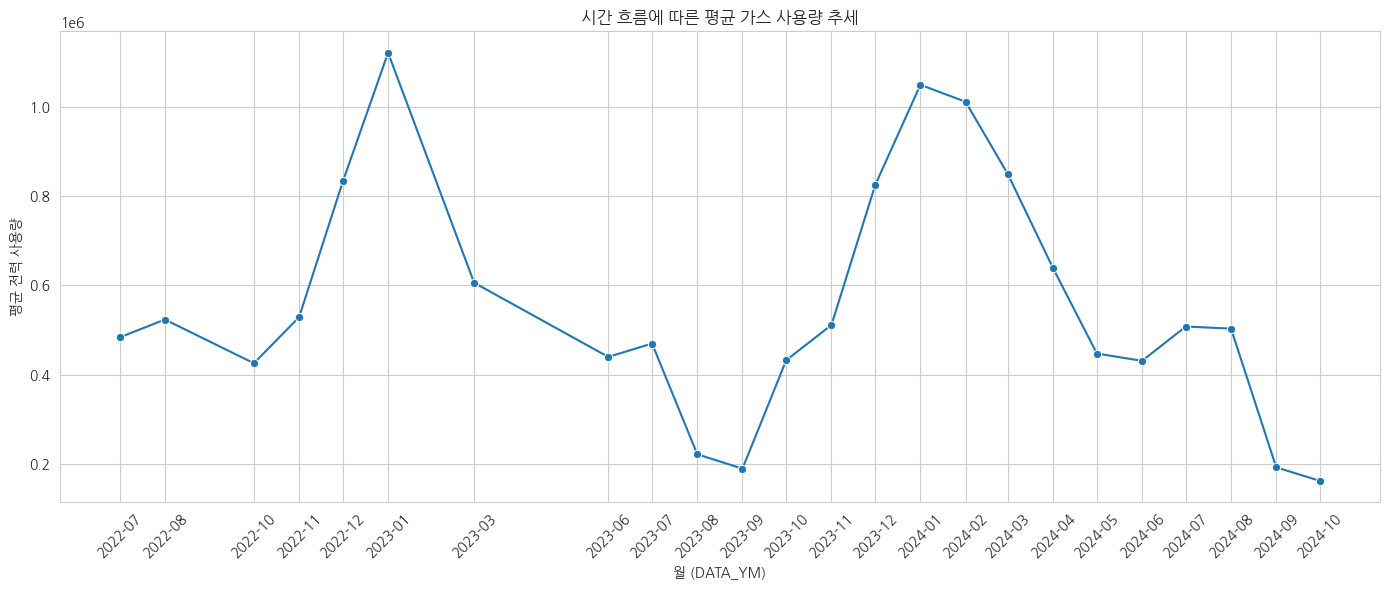

In [182]:

# 월별 평균 전력 사용량 계산
monthly_usage = df.groupby('DATA_YM')['TOTAL_GAS'].mean()

# 시각화
plt.figure(figsize=(14, 6))
sns.lineplot(x=monthly_usage.index, y=monthly_usage.values, marker='o')

# X축에 모든 월 표시
plt.xticks(ticks=monthly_usage.index, labels=monthly_usage.index.strftime('%Y-%m'), rotation=45)

plt.title('시간 흐름에 따른 평균 가스 사용량 추세')
plt.xlabel('월 (DATA_YM)')
plt.ylabel('평균 전력 사용량')
plt.grid(True)
plt.tight_layout()
plt.show()


### 전기
✅ 주요 패턴:

여름 (7~8월): 전력 사용량 급증, 에어컨 등 냉방 수요 때문일 확률 큼.

가을 (9~10월): 급감 → 냉방도 난방도 거의 없는 계절이라 사용량 최소.

겨울 (12~2월): 다소 상승, 난방용 전기 수요로 해석 가능.

봄 (3~5월): 상대적으로 낮은 편. 전기 사용 수요가 많지 않은 계절.

전체 흐름: 여름 피크 - 가을 저점 - 겨울 중간 - 봄 저점 형태 반복.

### 가스
✅ 주요 패턴:
11월 ~ 3월 (겨울철) 피크

C:\Users\dlwng\AppData\Local\Temp\ipykernel_22804\3995804323.py:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x='SIDO_NM', y='TOTAL_ELEC', estimator='mean', ci=None, palette='viridis')
C:\Users\dlwng\AppData\Local\Temp\ipykernel_22804\3995804323.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='SIDO_NM', y='TOTAL_ELEC', estimator='mean', ci=None, palette='viridis')


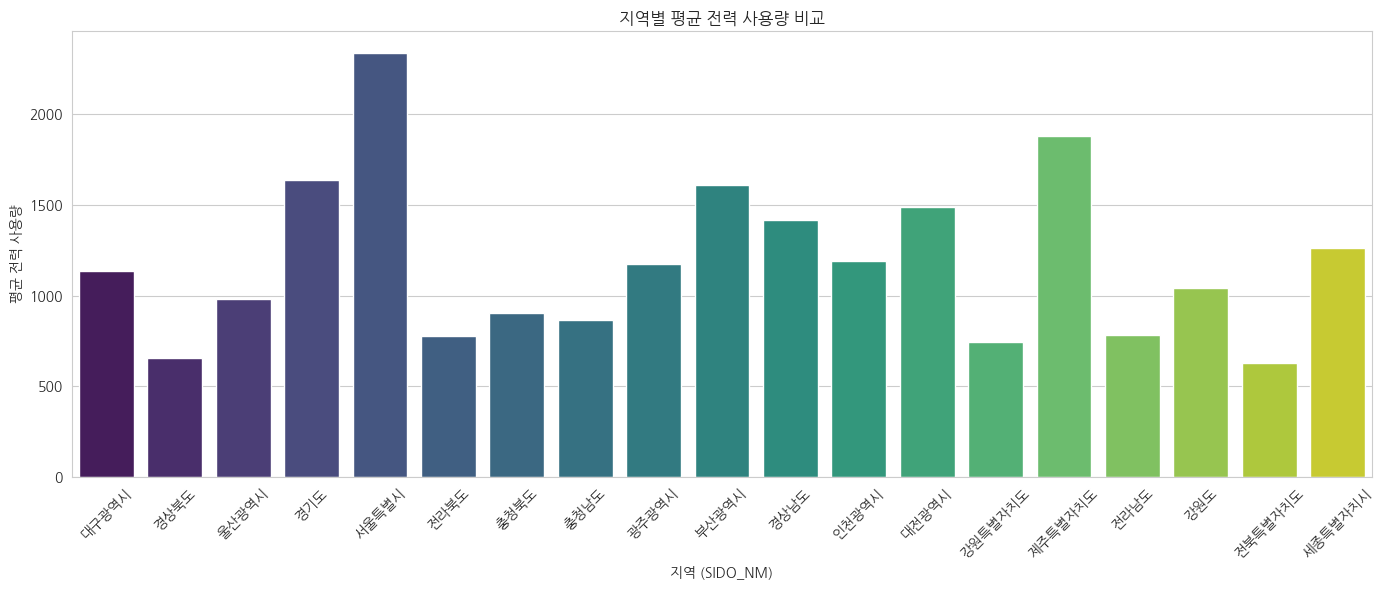

In [183]:
import matplotlib.pyplot as plt
import seaborn as sns

# seaborn 스타일 설정
#sns.set_style('whitegrid')

plt.figure(figsize=(14, 6))

# 시각화
sns.barplot(data=df, x='SIDO_NM', y='TOTAL_ELEC', estimator='mean', ci=None, palette='viridis')

# 레이블 회전 및 제목
plt.xticks(rotation=45)
plt.title('지역별 평균 전력 사용량 비교')
plt.ylabel('평균 전력 사용량')
plt.xlabel('지역 (SIDO_NM)')

plt.tight_layout()
plt.show()


In [184]:
# 6. 계절변수 생성
# 월 추출
df['MONTH'] = df['DATA_YM'].dt.month

# 계절 변수 만들기
def get_season(month):
    if month in [3, 4, 5]:
        return '봄'
    elif month in [6, 7, 8]:
        return '여름'
    elif month in [9, 10, 11]:
        return '가을'
    else:
        return '겨울'

df['SEASON'] = df['MONTH'].apply(get_season)

In [185]:
# pandas의 get_dummies 사용
season_ohe = pd.get_dummies(df['SEASON'], prefix='SEASON')

# 기존 df에 붙이기
df = pd.concat([df, season_ohe], axis=1)

In [186]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25344 entries, 0 to 26098
Data columns (total 32 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   DATA_YM       25344 non-null  datetime64[ns]
 1   AREA_ID       25344 non-null  int64         
 2   AREA_NM       25344 non-null  object        
 3   DIST_CD       25344 non-null  object        
 4   DIST_NM       25344 non-null  object        
 5   TOTAL_BIDG    25344 non-null  float64       
 6   FAC_NEIGH_1   25344 non-null  float64       
 7   FAC_NEIGH_2   25344 non-null  float64       
 8   FAC_CULT_MTG  25344 non-null  float64       
 9   FAC_RELG      25344 non-null  float64       
 10  FAC_RETAIL    25344 non-null  float64       
 11  FAC_MEDI      25344 non-null  float64       
 12  FAC_YOSE      25344 non-null  float64       
 13  FAC_TRAIN     25344 non-null  float64       
 14  FAC_SPORT     25344 non-null  float64       
 15  FAC_STAY      25344 non-null  float64    

## 1. 건물구성 기반 클러스터링 : CLUSTER_BLDG_TYPE

In [187]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

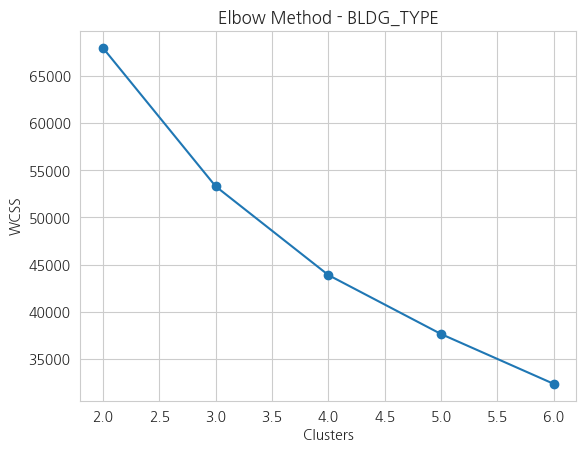

C:\Users\dlwng\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


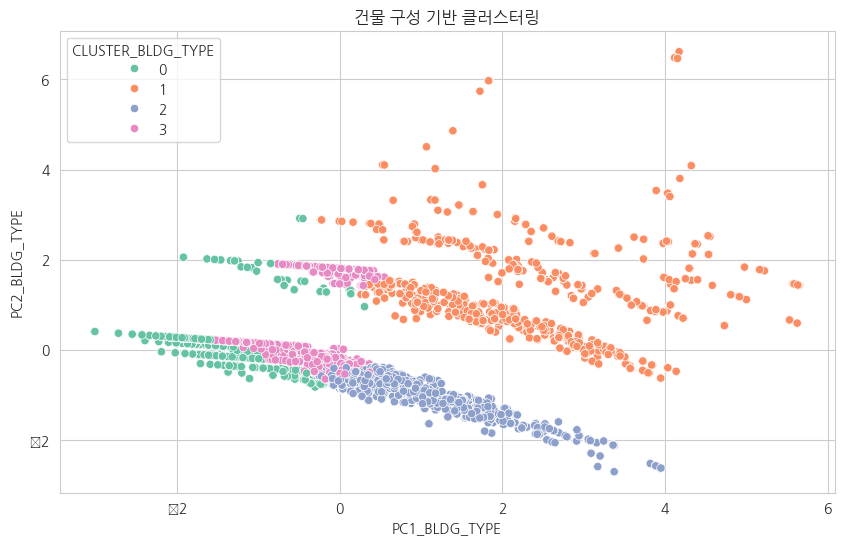

In [188]:
# 1) 수치형 변수만 골라서 로그 변환
features_bldg = ['TOTAL_BIDG', 'FAC_RETAIL', 'FAC_STAY', 'FAC_CULT_MTG']
df_log = df.copy()
df_log[features_bldg] = df_log[features_bldg].apply(lambda col: np.log1p(col))

# 2) 변환된 df_log 로 스케일링
scaler = StandardScaler()
X_bldg = scaler.fit_transform(df_log[features_bldg])

# 2. 스케일링
scaler = StandardScaler()
X_bldg = scaler.fit_transform(df_log[features_bldg])

# 3. Elbow Method
wcss = []
for i in range(2, 7):
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
    kmeans.fit(X_bldg)
    wcss.append(kmeans.inertia_)

plt.plot(range(2, 7), wcss, marker='o')
plt.title('Elbow Method - BLDG_TYPE')
plt.xlabel('Clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

# 4. 클러스터링 및 시각화
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df['CLUSTER_BLDG_TYPE'] = kmeans.fit_predict(X_bldg)

pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_bldg)
df['PC1_BLDG_TYPE'] = pca_result[:, 0]
df['PC2_BLDG_TYPE'] = pca_result[:, 1]

plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x='PC1_BLDG_TYPE', y='PC2_BLDG_TYPE', hue='CLUSTER_BLDG_TYPE', palette='Set2')
plt.title('건물 구성 기반 클러스터링')
plt.grid(True)
plt.show()


## 2. 계절 + 연도 조합 기반 gas 클러스터링 CLUSTER_SEASONAL

C:\Users\dlwng\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 53364 (\N{HANGUL SYLLABLE KEUL}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\dlwng\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 47084 (\N{HANGUL SYLLABLE REO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\dlwng\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\dlwng\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 53552 (\N{HANGUL SYLLABLE TEO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\dlwng\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE 

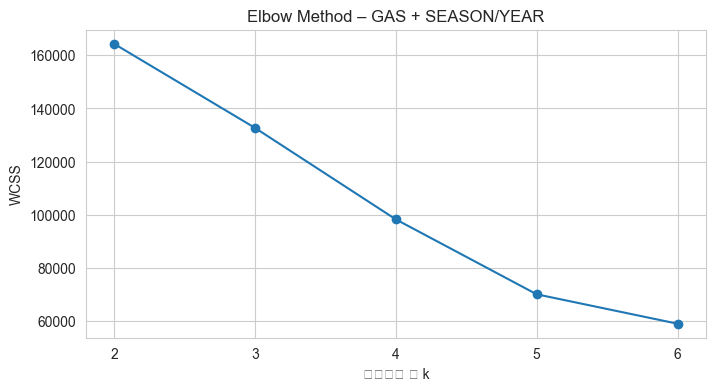

C:\Users\dlwng\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\dlwng\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\dlwng\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\dlwng\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 50857 (\N{HANGUL SYLLABLE YONG}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\dlwng\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 47049 (\N{HANGUL SYLLABLE RY

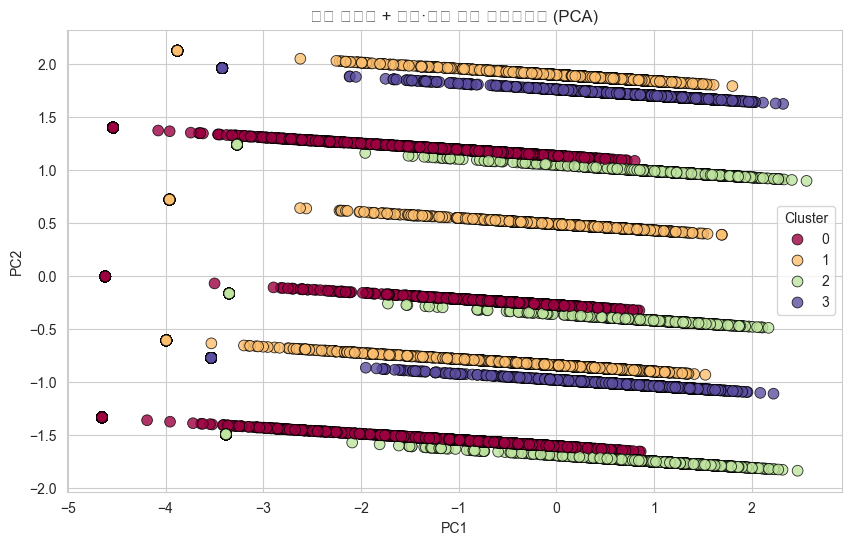

In [189]:
# seaborn 스타일
sns.set_style("whitegrid")

# 0. (선택) 이상치 처리: TOTAL_GAS==0 → log1p 문제 없으니 생략 가능

# 1. 변수 지정
features = [
    'TOTAL_GAS', 'CMRC_GAS',
    'SEASON_봄', 'SEASON_여름', 'SEASON_가을', 'SEASON_겨울',
    'YEAR_2023', 'YEAR_2024'
]

# 2. 로그변환 (가스만)
df_log = df.copy()
df_log[['TOTAL_GAS','CMRC_GAS']] = df_log[['TOTAL_GAS','CMRC_GAS']].apply(lambda x: np.log1p(x))

# 3. 스케일링
scaler = StandardScaler()
X = scaler.fit_transform(df_log[features])

# 4. Elbow Method (k=2~6)
wcss = []
for k in range(2, 7):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X)
    wcss.append(km.inertia_)

plt.figure(figsize=(8,4))
plt.plot(range(2,7), wcss, marker='o')
plt.title('Elbow Method – GAS + SEASON/​YEAR')
plt.xlabel('클러스터 수 k')
plt.ylabel('WCSS')
plt.xticks(range(2,7))
plt.grid(True)
plt.show()

# 5. KMeans 클러스터링 (예: k=3)
k_opt = 4
kmeans = KMeans(n_clusters=k_opt, random_state=42, n_init=10)
df['CLUSTER_GAS_SEASON'] = kmeans.fit_predict(X)

# 6. PCA 2차원 투영
pca = PCA(n_components=2, random_state=42)
pc = pca.fit_transform(X)
df['PC1_GAS_SEASON'] = pc[:,0]
df['PC2_GAS_SEASON'] = pc[:,1]

# 7. 시각화
plt.figure(figsize=(10,6))
sns.scatterplot(
    x='PC1_GAS_SEASON', y='PC2_GAS_SEASON',
    hue='CLUSTER_GAS_SEASON', palette='Spectral',
    data=df, s=60, alpha=0.8, edgecolor='k'
)
plt.title('가스 사용량 + 계절·연도 기반 클러스터링 (PCA)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title='Cluster', loc='best')
plt.grid(True)
plt.show()


## 3. 종합 입지 특성 기반 클러스터링 CLUSTER_REGION_MIXED

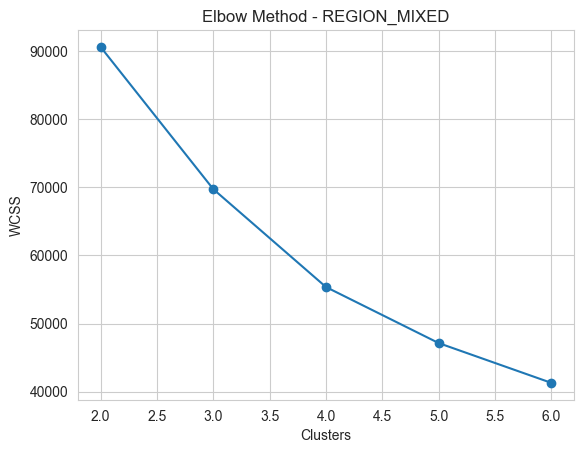

C:\Users\dlwng\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51333 (\N{HANGUL SYLLABLE JONG}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\dlwng\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 54633 (\N{HANGUL SYLLABLE HAB}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\dlwng\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51077 (\N{HANGUL SYLLABLE IB}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\dlwng\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\dlwng\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 53945 (\N{HANGUL SYLLABLE TE

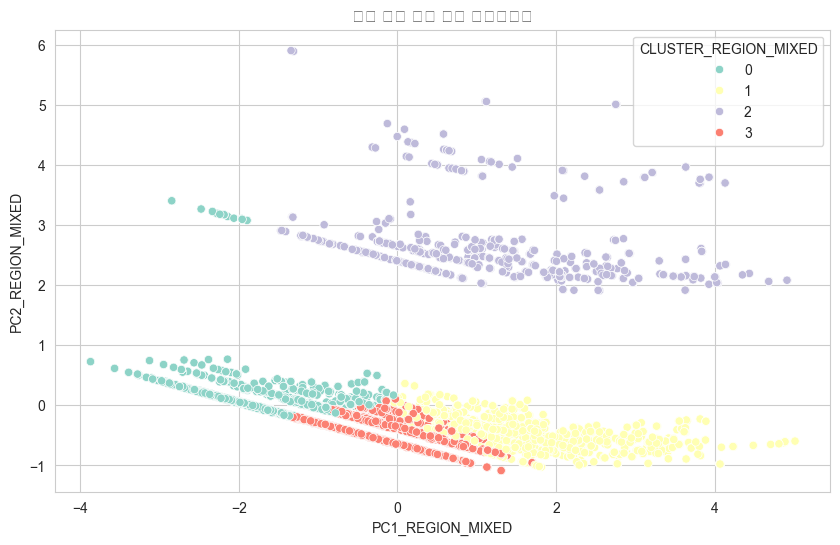

In [190]:
# 1. 변수 선택
features_mix = ['TOTAL_BIDG', 'FAC_RETAIL', 'FAC_NEIGH_1', 'FAC_MEDI', 'FAC_SPORT']
df_log = df.copy()
df_log[features_mix] = df_log[features_mix].apply(lambda x: np.log1p(x))

# 2. 스케일링
scaler = StandardScaler()
X_mix = scaler.fit_transform(df_log[features_mix])

# 3. Elbow Method
wcss = []
for i in range(2, 7):
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
    kmeans.fit(X_mix)
    wcss.append(kmeans.inertia_)

plt.plot(range(2, 7), wcss, marker='o')
plt.title('Elbow Method - REGION_MIXED')
plt.xlabel('Clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

# 4. 클러스터링 및 시각화
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df['CLUSTER_REGION_MIXED'] = kmeans.fit_predict(X_mix)

pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_mix)
df['PC1_REGION_MIXED'] = pca_result[:, 0]
df['PC2_REGION_MIXED'] = pca_result[:, 1]

plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x='PC1_REGION_MIXED', y='PC2_REGION_MIXED', hue='CLUSTER_REGION_MIXED', palette='Set3')
plt.title('종합 입지 특성 기반 클러스터링')
plt.grid(True)
plt.show()


In [191]:
df['GAS_PER_BUILDING'] = df['TOTAL_GAS'] / df['TOTAL_BIDG']
df['CMRC_GAS_RATIO']   = df['CMRC_GAS']  / df['TOTAL_GAS']


In [192]:
# TOTAL_BIDG가 0이면서 TOTAL_GAS > 0인 행만 골라 보기
anomalies = df[(df['TOTAL_GAS'] == 0) & (df['TOTAL_BIDG']>1 )]
anomalies[['AREA_ID','DIST_CD','TOTAL_BIDG','CMRC_GAS','TOTAL_GAS','TOTAL_ELEC']]

,AREA_ID,DIST_CD,TOTAL_BIDG,CMRC_GAS,TOTAL_GAS,TOTAL_ELEC
8,9684,47930,173.0,0,0,49.677
30,9936,41590,3.0,0,0,5.407
57,9577,48240,81.0,0,0,307.454
64,9800,50130,110.0,0,0,343.153
70,10272,43720,350.0,0,0,478.860
...,...,...,...,...,...,...
26061,9409,42150,407.0,0,0,1771.946
26062,9556,48740,110.0,0,0,179.969
26070,9682,47770,84.0,0,0,6.112
26088,10365,51810,91.0,0,0,191.063


In [193]:
# seaborn 스타일
sns.set_style("whitegrid")

# ── 0. 데이터 복사 (원본 유지) ─────────────────────────────
df_proc = df.copy()

# ── 1. 이상치 처리: 건물 수 0이면서 가스 또는 전력 사용량>0인 경우 ─────────────
mask_anom = (df_proc['TOTAL_BIDG'] == 0) & (
    (df_proc['TOTAL_GAS'] > 0) | (df_proc['TOTAL_ELEC'] > 0)
)
print(f"이상치 행 개수: {mask_anom.sum()}개")
# 최소 1개 건물로 치환
df_proc.loc[mask_anom, 'TOTAL_BIDG'] = 1

# ── 2. 파생변수 생성 ───────────────────────────────────────
df_proc['GAS_PER_BUILDING'] = df_proc['TOTAL_GAS'] / df_proc['TOTAL_BIDG']
df_proc['CMRC_GAS_RATIO']   = df_proc['CMRC_GAS']  / df_proc['TOTAL_GAS'].replace(0, np.nan)

## ── 3. inf/NaN 제거 ───────────────────────────────────────
df_proc.replace([np.inf, -np.inf], np.nan, inplace=True)
#df_proc.dropna(subset=['GAS_PER_BUILDING', 'CMRC_GAS_RATIO'], inplace=True)

이상치 행 개수: 0개


In [194]:
# 1. 각 컬럼별 NaN 개수 확인
print("컬럼별 NaN 개수:")
print(df_proc.isna().sum())

# 2. NaN이 하나라도 있는 행 개수 확인
num_rows_with_nan = df_proc.isna().any(axis=1).sum()
print(f"\nNaN이 하나라도 있는 행 개수: {num_rows_with_nan}")

# 3. NaN이 있는 샘플 행 일부 출력
print("\nNaN 포함된 행 예시:")
print(df_proc[df_proc.isna().any(axis=1)].head())

# 4. GAS_PER_BUILDING 또는 CMRC_GAS_RATIO에서 NaN 발생 인덱스 확인
nan_indices = df_proc[
    df_proc['GAS_PER_BUILDING'].isna() |
    df_proc['CMRC_GAS_RATIO'].isna()
].index
print("\n파생변수 NaN 발생 인덱스:")
print(nan_indices.tolist())


컬럼별 NaN 개수:
DATA_YM                    0
AREA_ID                    0
AREA_NM                    0
DIST_CD                    0
DIST_NM                    0
TOTAL_BIDG                 0
FAC_NEIGH_1                0
FAC_NEIGH_2                0
FAC_CULT_MTG               0
FAC_RELG                   0
FAC_RETAIL                 0
FAC_MEDI                   0
FAC_YOSE                   0
FAC_TRAIN                  0
FAC_SPORT                  0
FAC_STAY                   0
FAC_LEISURE                0
TOTAL_GAS                  0
CMRC_GAS                   0
TOTAL_ELEC                 0
SIDO_CD                    0
ADDR_CD                    0
SIDO_NM                    0
YEAR_2022                  0
YEAR_2023                  0
YEAR_2024                  0
MONTH                      0
SEASON                     0
SEASON_가을                  0
SEASON_겨울                  0
SEASON_봄                   0
SEASON_여름                  0
CLUSTER_BLDG_TYPE          0
PC1_BLDG_TYPE              0
PC

In [195]:
# seaborn 스타일
sns.set_style("whitegrid")

# ── 0. 데이터 복사 (원본 유지) ─────────────────────────────
df_proc = df.copy()

# ── 1. 이상치 처리: 건물 수 0이면서 가스 또는 전력 사용량>0인 경우 ─────────────
mask_anom = (df_proc['TOTAL_BIDG'] == 0) & (
    (df_proc['TOTAL_GAS'] > 0) | (df_proc['TOTAL_ELEC'] > 0)
)
print(f"이상치 행 개수: {mask_anom.sum()}개")
# 최소 1개 건물로 치환
df_proc.loc[mask_anom, 'TOTAL_BIDG'] = 1

# ── 2. 파생변수 생성 ───────────────────────────────────────
df_proc['GAS_PER_BUILDING'] = df_proc['TOTAL_GAS'] / df_proc['TOTAL_BIDG']
df_proc['CMRC_GAS_RATIO']   = df_proc['CMRC_GAS']  / df_proc['TOTAL_GAS'].replace(0, np.nan)

## ── 3. inf/NaN 제거 ───────────────────────────────────────
df_proc.replace([np.inf, -np.inf], np.nan, inplace=True)
#df_proc.dropna(subset=['GAS_PER_BUILDING', 'CMRC_GAS_RATIO'], inplace=True)

# ── 4. 로그변환 ───────────────────────────────────────────
features = ['GAS_PER_BUILDING', 'CMRC_GAS_RATIO']
df_proc[features] = df_proc[features].apply(np.log1p)

# ── 5. 스케일링 ───────────────────────────────────────────
scaler = StandardScaler()
X_ratio = scaler.fit_transform(df_proc[features])

# ── 6. Elbow Method (k=2~6) ───────────────────────────────
wcss = []
for k in range(2, 7):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_ratio)
    wcss.append(km.inertia_)

plt.figure(figsize=(8,4))
plt.plot(range(2,7), wcss, marker='o')
plt.title('Elbow Method – GAS_PER_BUILDING & CMRC_GAS_RATIO')
plt.xlabel('Number of Clusters k')
plt.ylabel('WCSS')
plt.xticks(range(2,7))
plt.grid(True)
plt.show()

# ── 7. KMeans 클러스터링 (예: k=3) ─────────────────────────
k_opt = 4
km_final = KMeans(n_clusters=k_opt, random_state=42, n_init=10)
df_proc['CLUSTER_GAS_BLDG'] = km_final.fit_predict(X_ratio)

# ── 8. PCA 2D 투영 ───────────────────────────────────────
pca = PCA(n_components=2, random_state=42)
pca_res = pca.fit_transform(X_ratio)
df_proc['PC1_GAS_BLDG'] = pca_res[:,0]
df_proc['PC2_GAS_BLDG'] = pca_res[:,1]

# ── 9. 시각화 ─────────────────────────────────────────────
plt.figure(figsize=(10,6))
sns.scatterplot(
    x='PC1_GAS_BLDG', y='PC2_GAS_BLDG',
    hue='CLUSTER_GAS_BLDG', palette='Accent',
    data=df_proc, s=60, alpha=0.8, edgecolor='k'
)
plt.title('가스/건물 비율 기반 클러스터링 (PCA)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title='Cluster', loc='best')
plt.grid(True)
plt.show()

이상치 행 개수: 0개


ValueError: Input X contains NaN.
KMeans does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [197]:
df

,DATA_YM,AREA_ID,AREA_NM,DIST_CD,DIST_NM,TOTAL_BIDG,FAC_NEIGH_1,FAC_NEIGH_2,FAC_CULT_MTG,FAC_RELG,...,PC1_BLDG_TYPE,PC2_BLDG_TYPE,CLUSTER_GAS_SEASON,PC1_GAS_SEASON,PC2_GAS_SEASON,CLUSTER_REGION_MIXED,PC1_REGION_MIXED,PC2_REGION_MIXED,GAS_PER_BUILDING,CMRC_GAS_RATIO
0,2023-03-01,9626,중앙로역_4,27110,중구,538.0,266.0,88.0,6.0,3.0,...,4.031227,3.476904,3,1.023197,-1.041213,1,3.026374,-0.754404,961.933086,0.900584
1,2023-03-01,10350,황리단길,47130,경주시,765.0,72.0,174.0,1.0,0.0,...,1.920070,0.820769,3,0.874141,-1.032442,1,1.528829,-0.732473,421.805229,0.985937
2,2022-12-01,9547,농소1동,31200,북구,343.0,74.0,161.0,1.0,3.0,...,0.231858,1.777699,2,1.386540,-0.444082,1,1.370235,-0.733799,2687.588921,0.788487
3,2023-12-01,9995,심석고등학교,41360,남양주시,129.0,4.0,14.0,0.0,1.0,...,-0.972662,0.143751,2,0.903225,-1.746413,3,-1.066976,-0.283563,1752.674419,0.990522
4,2023-01-01,9248,고덕역,11740,강동구,34.0,2.0,14.0,0.0,0.0,...,-0.992184,-0.197605,2,1.515583,-1.782532,0,-1.414119,0.128598,55436.882353,0.470211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26094,2023-12-01,9816,아중고려병원,52113,전주시 덕진구,85.0,13.0,16.0,0.0,0.0,...,1.414368,-1.355333,2,-3.381792,-1.494857,2,0.978981,2.752424,0.000000,NaN
26095,2023-07-01,10150,부평문화의거리,28237,부평구,334.0,155.0,81.0,0.0,0.0,...,1.465786,-1.168492,1,0.570735,-0.877016,1,1.484494,-0.702536,1977.260479,0.565044
26096,2023-07-01,9860,고창공용버스터미널_2,45790,고창군,311.0,135.0,30.0,0.0,1.0,...,0.572957,-0.644242,1,-0.120183,-0.836431,3,1.138207,-0.748084,276.807074,0.627179
26097,2022-11-01,10257,홈플러스,43113,청주시 흥덕구,62.0,9.0,4.0,0.0,0.0,...,-1.275156,0.182884,0,-0.682611,-0.236567,3,-1.094096,-0.261178,1574.564516,0.702181


In [198]:
# df_proc의 NaN 값 확인 코드

# 1) 각 컬럼별 NaN 개수 확인
print("컬럼별 NaN 개수:")
print(df_proc.isna().sum())

# 2) 전체 NaN이 있는 행 개수 확인
num_rows_with_nan = df_proc.isna().any(axis=1).sum()
print(f"\nNaN이 하나라도 있는 행 개수: {num_rows_with_nan}")

# 3) NaN이 있는 행 샘플 일부 출력
print("\nNaN이 있는 행 샘플:")
display(df_proc[df_proc.isna().any(axis=1)].head())

# 4) 특정 파생변수 컬럼의 NaN 인덱스 출력 (예: GAS_PER_BUILDING, CMRC_GAS_RATIO)
nan_indices = df_proc[df_proc['GAS_PER_BUILDING'].isna() | df_proc['CMRC_GAS_RATIO'].isna()].index
print("\n파생변수 NaN 발생 인덱스:")
print(nan_indices.to_list())


컬럼별 NaN 개수:
DATA_YM                    0
AREA_ID                    0
AREA_NM                    0
DIST_CD                    0
DIST_NM                    0
TOTAL_BIDG                 0
FAC_NEIGH_1                0
FAC_NEIGH_2                0
FAC_CULT_MTG               0
FAC_RELG                   0
FAC_RETAIL                 0
FAC_MEDI                   0
FAC_YOSE                   0
FAC_TRAIN                  0
FAC_SPORT                  0
FAC_STAY                   0
FAC_LEISURE                0
TOTAL_GAS                  0
CMRC_GAS                   0
TOTAL_ELEC                 0
SIDO_CD                    0
ADDR_CD                    0
SIDO_NM                    0
YEAR_2022                  0
YEAR_2023                  0
YEAR_2024                  0
MONTH                      0
SEASON                     0
SEASON_가을                  0
SEASON_겨울                  0
SEASON_봄                   0
SEASON_여름                  0
CLUSTER_BLDG_TYPE          0
PC1_BLDG_TYPE              0
PC

,DATA_YM,AREA_ID,AREA_NM,DIST_CD,DIST_NM,TOTAL_BIDG,FAC_NEIGH_1,FAC_NEIGH_2,FAC_CULT_MTG,FAC_RELG,...,PC1_BLDG_TYPE,PC2_BLDG_TYPE,CLUSTER_GAS_SEASON,PC1_GAS_SEASON,PC2_GAS_SEASON,CLUSTER_REGION_MIXED,PC1_REGION_MIXED,PC2_REGION_MIXED,GAS_PER_BUILDING,CMRC_GAS_RATIO
8,2023-03-01,9684,죽변면,47930,울진군,173.0,15.0,10.0,0.0,0.0,...,-0.850929,0.128003,3,-3.533775,-0.773670,3,-0.452982,-0.490084,0.0,NaN
17,2024-10-01,10317,팔공산 동화사,27140,동구,0.0,0.0,0.0,0.0,0.0,...,-3.005239,0.406698,0,-4.537317,1.399058,0,-3.870039,0.725192,NaN,NaN
30,2024-09-01,9936,사강시장,41590,화성시,3.0,0.0,2.0,0.0,0.0,...,-2.426353,0.331810,0,-4.537317,1.399058,0,-3.263406,0.500674,0.0,NaN
57,2023-09-01,9577,중앙로,48240,사천시,81.0,8.0,29.0,0.0,0.0,...,0.218934,-0.528990,0,-4.650839,-1.334286,3,-1.022815,-0.289436,0.0,NaN
64,2023-11-01,9800,동흥동,50130,서귀포시,110.0,15.0,30.0,1.0,0.0,...,-0.240470,1.838802,0,-4.650839,-1.334286,3,-0.649691,-0.417281,0.0,NaN



파생변수 NaN 발생 인덱스:
[8, 17, 30, 57, 64, 70, 79, 84, 95, 101, 132, 139, 149, 161, 198, 242, 245, 293, 310, 359, 360, 367, 376, 382, 390, 397, 400, 401, 456, 467, 470, 478, 491, 506, 508, 514, 517, 533, 556, 573, 575, 611, 620, 637, 641, 651, 656, 662, 668, 679, 680, 681, 696, 697, 719, 727, 750, 759, 794, 804, 829, 830, 833, 839, 846, 852, 877, 889, 893, 928, 953, 965, 971, 992, 993, 1009, 1026, 1045, 1049, 1052, 1084, 1087, 1090, 1109, 1119, 1127, 1137, 1145, 1178, 1205, 1222, 1241, 1242, 1246, 1247, 1249, 1258, 1276, 1279, 1296, 1316, 1323, 1338, 1340, 1354, 1368, 1382, 1397, 1421, 1431, 1461, 1466, 1477, 1478, 1479, 1485, 1490, 1494, 1511, 1522, 1544, 1545, 1561, 1579, 1593, 1598, 1636, 1651, 1658, 1670, 1680, 1684, 1690, 1698, 1700, 1710, 1757, 1764, 1766, 1794, 1801, 1808, 1817, 1844, 1851, 1852, 1863, 1869, 1904, 1914, 1926, 1929, 1937, 1960, 1990, 1993, 2009, 2032, 2115, 2129, 2155, 2158, 2163, 2173, 2183, 2203, 2208, 2218, 2219, 2251, 2270, 2279, 2307, 2321, 2343, 2425, 2476, 2484

In [199]:
#from sklearn.metrics import silhouette_score

# 실루엣 점수 계산
#silhouette = silhouette_score(X_train, kmeans.labels_)
#print(f'Silhouette Score: {silhouette}')

In [200]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25344 entries, 0 to 26098
Data columns (total 43 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   DATA_YM               25344 non-null  datetime64[ns]
 1   AREA_ID               25344 non-null  int64         
 2   AREA_NM               25344 non-null  object        
 3   DIST_CD               25344 non-null  object        
 4   DIST_NM               25344 non-null  object        
 5   TOTAL_BIDG            25344 non-null  float64       
 6   FAC_NEIGH_1           25344 non-null  float64       
 7   FAC_NEIGH_2           25344 non-null  float64       
 8   FAC_CULT_MTG          25344 non-null  float64       
 9   FAC_RELG              25344 non-null  float64       
 10  FAC_RETAIL            25344 non-null  float64       
 11  FAC_MEDI              25344 non-null  float64       
 12  FAC_YOSE              25344 non-null  float64       
 13  FAC_TRAIN            

In [201]:
df.describe()

,DATA_YM,AREA_ID,TOTAL_BIDG,FAC_NEIGH_1,FAC_NEIGH_2,FAC_CULT_MTG,FAC_RELG,FAC_RETAIL,FAC_MEDI,FAC_YOSE,...,PC1_BLDG_TYPE,PC2_BLDG_TYPE,CLUSTER_GAS_SEASON,PC1_GAS_SEASON,PC2_GAS_SEASON,CLUSTER_REGION_MIXED,PC1_REGION_MIXED,PC2_REGION_MIXED,GAS_PER_BUILDING,CMRC_GAS_RATIO
count,25344,25344.000000,25344.000000,25344.000000,25344.000000,25344.000000,25344.000000,25344.000000,25344.000000,25344.000000,...,2.534400e+04,2.534400e+04,25344.000000,2.534400e+04,2.534400e+04,25344.000000,2.534400e+04,2.534400e+04,2.511300e+04,23573.000000
mean,2023-08-22 13:10:34.090908928,9740.560646,178.445668,44.198351,42.601010,0.289654,0.494634,1.087240,0.574021,0.580414,...,-3.252168e-17,-2.803593e-17,1.396346,2.803593e-17,-8.550960e-18,1.751144,1.548985e-17,-1.289653e-17,2.018603e+04,0.716091
min,2022-07-01 00:00:00,9138.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-3.005239e+00,-2.705324e+00,0.000000,-4.650839e+00,-1.838426e+00,0.000000,-3.870039e+00,-1.087964e+00,0.000000e+00,0.000000
25%,2023-01-01 00:00:00,9438.000000,51.000000,7.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.016658e+00,-5.159050e-01,0.000000,-4.411551e-01,-1.042536e+00,1.000000,-9.464928e-01,-5.266602e-01,5.418113e+02,0.542140
50%,2023-09-01 00:00:00,9734.000000,116.000000,19.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-2.196360e-01,-4.298711e-02,1.000000,3.461266e-01,-2.681735e-01,2.000000,-5.261131e-02,-3.163815e-01,2.082021e+03,0.814832
75%,2024-04-01 00:00:00,10040.000000,245.000000,51.000000,59.000000,0.000000,1.000000,1.000000,1.000000,1.000000,...,8.141589e-01,2.266905e-01,2.000000,9.557824e-01,1.227648e+00,3.000000,9.082681e-01,2.194147e-02,6.893504e+03,0.970012
max,2024-10-01 00:00:00,10376.000000,1530.000000,553.000000,872.000000,18.000000,15.000000,67.000000,7.000000,9.000000,...,5.648708e+00,6.616436e+00,3.000000,2.561784e+00,2.124364e+00,3.000000,5.014599e+00,5.901750e+00,1.147081e+07,1.000000
std,NaN,352.207922,188.527093,66.751244,51.046922,0.851306,0.945696,2.475609,1.047036,1.079050,...,1.425357e+00,8.877359e-01,1.099366,1.427657e+00,1.311382e+00,1.232532,1.527276e+00,9.822832e-01,2.087487e+05,0.292951


In [202]:
train[train['TOTAL_ELEC']==0].count()

DATA_YM         494
AREA_ID         494
AREA_NM         494
DIST_CD         494
DIST_NM         494
TOTAL_BIDG      494
FAC_NEIGH_1     494
FAC_NEIGH_2     494
FAC_CULT_MTG    494
FAC_RELG        494
FAC_RETAIL      494
FAC_MEDI        494
FAC_YOSE        494
FAC_TRAIN       494
FAC_SPORT       494
FAC_STAY        494
FAC_LEISURE     494
TOTAL_GAS       494
CMRC_GAS        494
TOTAL_ELEC      494
SIDO_CD         494
ADDR_CD         494
SIDO_NM         494
YEAR            494
dtype: int64

In [203]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25344 entries, 0 to 26098
Data columns (total 43 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   DATA_YM               25344 non-null  datetime64[ns]
 1   AREA_ID               25344 non-null  int64         
 2   AREA_NM               25344 non-null  object        
 3   DIST_CD               25344 non-null  object        
 4   DIST_NM               25344 non-null  object        
 5   TOTAL_BIDG            25344 non-null  float64       
 6   FAC_NEIGH_1           25344 non-null  float64       
 7   FAC_NEIGH_2           25344 non-null  float64       
 8   FAC_CULT_MTG          25344 non-null  float64       
 9   FAC_RELG              25344 non-null  float64       
 10  FAC_RETAIL            25344 non-null  float64       
 11  FAC_MEDI              25344 non-null  float64       
 12  FAC_YOSE              25344 non-null  float64       
 13  FAC_TRAIN            

# 모델링


In [204]:
# 타겟 설정
target = 'TOTAL_ELEC'

# 사용하지 않을 열
drop_cols = ['DATA_YM', 'AREA_ID', 'AREA_NM', 'DIST_NM', 'SIDO_CD', 'ADDR_CD', 'SIDO_NM', 'SEASON','CMRC_GAS_RATIO','GAS_PER_BUILDING' ]

# 피처 설정
features = df.drop(columns=drop_cols + [target]).columns

In [205]:
# Train / Test 분리 (train_test_split 사용)
X = df[features]
y = df[target]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [206]:

# 1. 클러스터링 변수들 (PC~ 및 CLUSTER) 제외한 변수들만 선택
columns_to_log = ['TOTAL_BIDG', 'FAC_NEIGH_1', 'FAC_NEIGH_2', 'FAC_CULT_MTG', 
                  'FAC_RELG', 'FAC_RETAIL', 'FAC_MEDI', 'FAC_YOSE', 'FAC_TRAIN', 
                  'FAC_SPORT', 'FAC_STAY', 'FAC_LEISURE', 'TOTAL_GAS', 'CMRC_GAS']

# 로그변환 (log1p 사용)
X_train_log = X_train.copy()
X_valid_log = X_valid.copy()

for col in columns_to_log:
    X_train_log[col] = np.log1p(X_train_log[col])
    X_valid_log[col] = np.log1p(X_valid_log[col])

In [207]:
# StandardScaler 적용
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_log[columns_to_log])
X_valid_scaled = scaler.transform(X_valid_log[columns_to_log])

X_train_scaled = pd.DataFrame(X_train_scaled, columns=columns_to_log)
X_valid_scaled = pd.DataFrame(X_valid_scaled, columns=columns_to_log)

In [208]:
# PC~, CLUSTER 계열 변수는 원래 데이터에서 그대로 붙여줌
cluster_features = ['CLUSTER_BLDG_TYPE', 'PC1_BLDG_TYPE', 'PC2_BLDG_TYPE', 'CLUSTER_GAS_SEASON', 'PC1_GAS_SEASON', 'PC2_GAS_SEASON','CLUSTER_REGION_MIXED','PC1_REGION_MIXED','PC2_REGION_MIXED']

X_train_scaled[cluster_features] = X_train[cluster_features].reset_index(drop=True)
X_valid_scaled[cluster_features] = X_valid[cluster_features].reset_index(drop=True)


In [219]:
# 5. 타겟 로그변환
y_train_log = np.log1p(y_train)
y_valid_log = np.log1p(y_valid)

# 6. 평가 함수 정의
def train_and_evaluate(name, model, X_train, y_train, X_valid, y_valid):
    """
    로그변환 학습 후, 역변환된 값으로 검증셋 평가까지 한 번에 처리.
    
    Parameters:
        name (str): 모델 이름
        model: 회귀 모델 객체
        X_train, X_valid: 입력 데이터 (스케일링된 상태)
        y_train, y_valid: 원래 타겟값 (로그 변환 전 상태로 넣기)
    """
    
    # 로그 변환
    y_train_log = np.log1p(y_train)

    # 학습
    model.fit(X_train, y_train_log)

    # 예측 (로그 스케일 → 역변환)
    y_pred_train_log = model.predict(X_train)
    y_pred_valid_log = model.predict(X_valid)

    y_pred_train = np.expm1(y_pred_train_log)
    y_pred_valid = np.expm1(y_pred_valid_log)

    # 평가 (원래 타겟과 비교)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    train_r2 = r2_score(y_train, y_pred_train)
    train_mae = mean_absolute_error(y_train, y_pred_train)

    valid_rmse = np.sqrt(mean_squared_error(y_valid, y_pred_valid))
    valid_r2 = r2_score(y_valid, y_pred_valid)
    valid_mae = mean_absolute_error(y_valid, y_pred_valid)

    print(f"\n📌 [{name}] 성능 평가")
    print(f"Train  - RMSE: {train_rmse:.4f}, R²: {train_r2:.4f}, MAE: {train_mae:.4f}")
    print(f"Valid  - RMSE: {valid_rmse:.4f}, R²: {valid_r2:.4f}, MAE: {valid_mae:.4f}")

    return {
        'train_rmse': train_rmse,
        'train_r2': train_r2,
        'train_mae': train_mae,
        'valid_rmse': valid_rmse,
        'valid_r2': valid_r2,
        'valid_mae': valid_mae,
        'model': model
    }
# 7. 모델 정의
xgb_model = XGBRegressor(n_estimators=100, random_state=42)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
lgbm_model = LGBMRegressor(n_estimators=100, random_state=42)

# 8. 모델별 평가 실행
train_and_evaluate("XGBoost", xgb_model, X_train_scaled, y_train, X_valid_scaled, y_valid)
train_and_evaluate("RandomForest", rf_model, X_train_scaled, y_train, X_valid_scaled, y_valid)
train_and_evaluate("LightGBM", lgbm_model, X_train_scaled, y_train, X_valid_scaled, y_valid)



📌 [XGBoost] 성능 평가
Train  - RMSE: 462.0553, R²: 0.9503, MAE: 212.5268
Valid  - RMSE: 522.1020, R²: 0.9320, MAE: 261.1084

📌 [RandomForest] 성능 평가
Train  - RMSE: 321.9931, R²: 0.9758, MAE: 113.4581
Valid  - RMSE: 587.8881, R²: 0.9138, MAE: 273.4863
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000454 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2971
[LightGBM] [Info] Number of data points in the train set: 20275, number of used features: 23
[LightGBM] [Info] Start training from score 6.506804

📌 [LightGBM] 성능 평가
Train  - RMSE: 851.7085, R²: 0.8310, MAE: 371.4252
Valid  - RMSE: 840.4510, R²: 0.8239, MAE: 381.5957


{'train_rmse': 851.7084712085518,
 'train_r2': 0.8309635560145987,
 'train_mae': 371.42522597982133,
 'valid_rmse': 840.4509731732476,
 'valid_r2': 0.8238549784960978,
 'valid_mae': 381.59573423723447,
 'model': LGBMRegressor(random_state=42)}

<Figure size 1000x800 with 0 Axes>

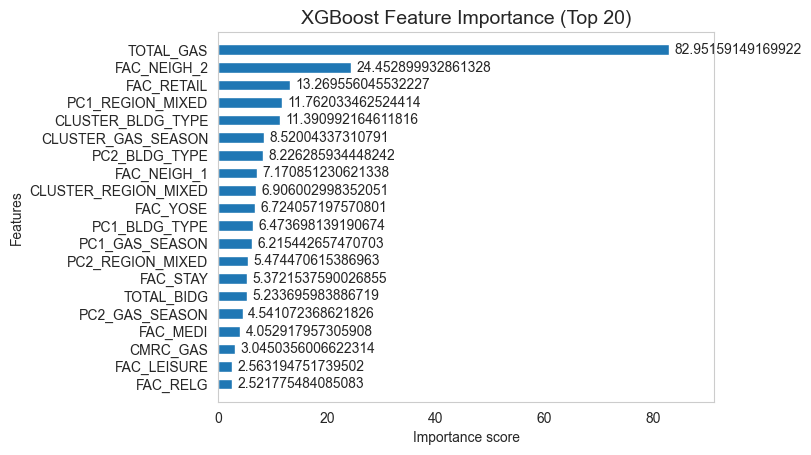

In [210]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

# XGB중요도 시각화
plt.figure(figsize=(10, 8))
plot_importance(xgb_model, max_num_features=20, importance_type='gain', height=0.6, grid=False)
plt.title('XGBoost Feature Importance (Top 20)', fontsize=14)
plt.show()

In [211]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import make_scorer

In [212]:
#kfold + gridsearchCV

# 1. 커스텀 스코어러 정의 (expm1 복원 후 RMSE)
def rmse_exp_score(y_true_log, y_pred_log):
    y_true = np.expm1(y_true_log)
    y_pred = np.expm1(y_pred_log)
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_exp_scorer = make_scorer(rmse_exp_score, greater_is_better=False)

# 2. 파라미터 그리드 정의
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0]
}

# 3. GridSearchCV 설정
xgb = XGBRegressor(random_state=42)
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring=rmse_exp_scorer,
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1,
    verbose=2
)

# 4. 로그 변환 후 학습
y_train_log = np.log1p(y_train)
grid_search.fit(X_train_scaled, y_train_log)

# 5. 최적 모델 정보 출력
print("✅ Best Parameters:", grid_search.best_params_)
print("✅ Best CV RMSE (expm1 기준):", -grid_search.best_score_)


Fitting 5 folds for each of 24 candidates, totalling 120 fits
✅ Best Parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1.0}
✅ Best CV RMSE (expm1 기준): 621.8687793091461


In [213]:
# 6. 최적 모델 추출
best_model = grid_search.best_estimator_

# 7. validation 예측 + 역변환
y_pred_valid_log = best_model.predict(X_valid_scaled)
y_pred_valid = np.expm1(y_pred_valid_log)

# 8. 평가
valid_rmse = np.sqrt(mean_squared_error(y_valid, y_pred_valid))
valid_r2 = r2_score(y_valid, y_pred_valid)
valid_mae = mean_absolute_error(y_valid, y_pred_valid)

print(f"\n📊 Validation 성능 (Best XGB Model)")
print(f"RMSE: {valid_rmse:.4f}, R²: {valid_r2:.4f}, MAE: {valid_mae:.4f}")


📊 Validation 성능 (Best XGB Model)
RMSE: 523.2556, R²: 0.9317, MAE: 257.6378


In [218]:
# 9. 변수 중요도 추출
importances = best_model.feature_importances_
columns = X_train.columns  # X_train이 DataFrame일 때만 가능!

importance_df = pd.DataFrame({
    'feature': columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# 10. 상위 20개 시각화
top_n = 20
plt.figure(figsize=(10, 6))
plt.barh(importance_df['feature'].head(top_n)[::-1],
         importance_df['importance'].head(top_n)[::-1])
plt.xlabel('Importance')
plt.title(f'Top {top_n} Feature Importances (XGBoost)')
plt.tight_layout()
plt.show()


ValueError: All arrays must be of the same length

In [ ]:
# test추출
# 1. 테스트셋 예측 (로그 스케일 → 역변환)
#y_test_pred_log = best_model.predict(X_test_scaled)
#y_test_pred = np.expm1(y_test_pred_log)

# 2. 결과 저장 (DataFrame 구성)
#submission = pd.DataFrame({
#    'y_pred': y_test_pred
#})

# 3. 저장 (형식: csv 또는 xlsx)
#submission.to_csv("submission.csv", index=False)
# 또는
# submission.to_excel("submission.xlsx", index=False)

#print("📁 테스트셋 예측 결과 저장 완료: submission.csv")


X_train_scaled_df.shape: (20275, 32)
Number of features (columns): 32
Length of feature_importances_: 23
Feature 길이 불일치 발견. 모델 길이에 맞게 피처명을 재정의합니다.


C:\Users\dlwng\AppData\Local\Temp\ipykernel_22804\1045551606.py:39: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\dlwng\AppData\Local\Temp\ipykernel_22804\1045551606.py:39: UserWarning: Glyph 51012 (\N{HANGUL SYLLABLE EUL}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\dlwng\AppData\Local\Temp\ipykernel_22804\1045551606.py:39: UserWarning: Glyph 44200 (\N{HANGUL SYLLABLE GYEO}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\dlwng\AppData\Local\Temp\ipykernel_22804\1045551606.py:39: UserWarning: Glyph 50872 (\N{HANGUL SYLLABLE UL}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\dlwng\AppData\Local\Temp\ipykernel_22804\1045551606.py:39: UserWarning: Glyph 50668 (\N{HANGUL SYLLABLE YEO}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\dlwng\AppData\Local\Temp\ipykernel_22804\1045551606.py:39: UserWarning: Glyph 47492 (\N{HANGUL SYLLABLE REUM}) missing from font(s) Arial.
  plt.tight_l

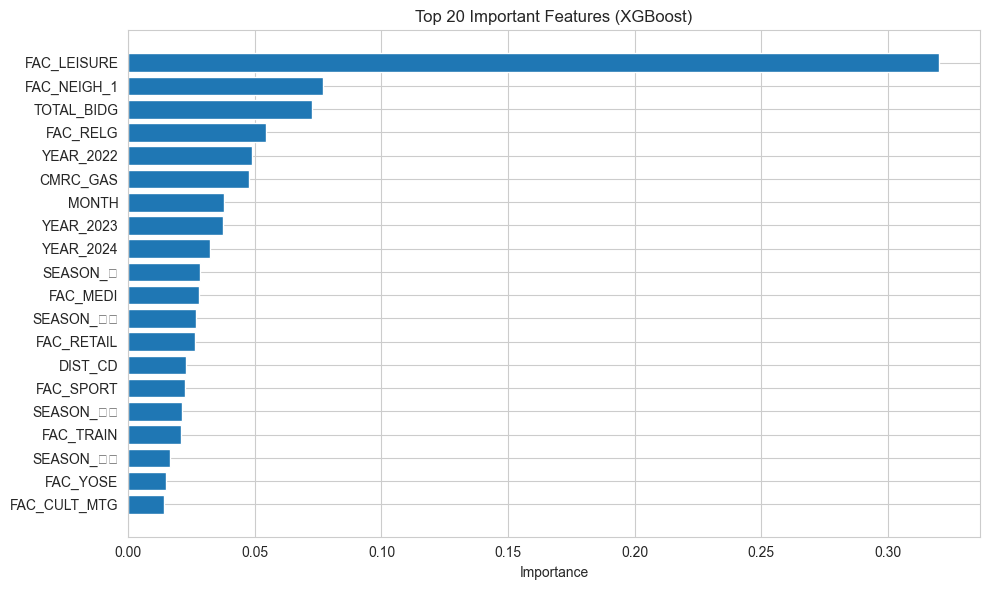


📊 Validation 성능 (Top 20 Features 기준)
RMSE: 805.0028, R²: 0.8384, MAE: 360.3719


In [215]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from xgboost import XGBRegressor

# 1. DataFrame 변환 (스케일링된 데이터에 원래의 컬럼명 부여)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_valid_scaled_df = pd.DataFrame(X_valid_scaled, columns=X_train.columns)

# 2. best_model으로부터 feature_importances_ 가져오기
importances = best_model.feature_importances_

# 두 길이 확인하기 (디버깅용)
print("X_train_scaled_df.shape:", X_train_scaled_df.shape)
print("Number of features (columns):", len(X_train_scaled_df.columns))
print("Length of feature_importances_:", len(importances))

# 3. 만약 길이가 다르면, 모델에서 반환한 길이에 맞게 컬럼명을 조정
if len(importances) != len(X_train_scaled_df.columns):
    print("Feature 길이 불일치 발견. 모델 길이에 맞게 피처명을 재정의합니다.")
    feature_names = X_train_scaled_df.columns[:len(importances)]
else:
    feature_names = X_train_scaled_df.columns

# 4. 변수 중요도 DataFrame 생성 및 정렬
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# 5. 시각화 (상위 20개 피처)
top_n = 20
plt.figure(figsize=(10, 6))
plt.barh(importance_df['feature'].head(top_n)[::-1],
         importance_df['importance'].head(top_n)[::-1])
plt.xlabel('Importance')
plt.title(f'Top {top_n} Important Features (XGBoost)')
plt.tight_layout()
plt.show()

# 6. 상위 변수 리스트 선정
top_features = importance_df['feature'].head(top_n).tolist()

# 7. 상위 변수만 골라 재학습 데이터 구성
X_train_top = X_train_scaled_df[top_features]
X_valid_top = X_valid_scaled_df[top_features]

# 8. 새 모델 인스턴스 생성 (GridSearchCV에서 찾은 최적 파라미터 사용)
xgb_top = XGBRegressor(**grid_search.best_params_, random_state=42)
xgb_top.fit(X_train_top, y_train_log)

# 9. Validation set에 대해 예측 및 역변환
y_pred_valid_top_log = xgb_top.predict(X_valid_top)
y_pred_valid_top = np.expm1(y_pred_valid_top_log)

# 10. 평가
valid_rmse_top = np.sqrt(mean_squared_error(y_valid, y_pred_valid_top))
valid_r2_top = r2_score(y_valid, y_pred_valid_top)
valid_mae_top = mean_absolute_error(y_valid, y_pred_valid_top)

print(f"\n📊 Validation 성능 (Top {top_n} Features 기준)")
print(f"RMSE: {valid_rmse_top:.4f}, R²: {valid_r2_top:.4f}, MAE: {valid_mae_top:.4f}")
